In [1]:
%load_ext autoreload

%autoreload 2

In [2]:

import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import glob
import numpy as np
import statistics as stats
import scipy
import math
import matplotlib.pyplot as plt
import random
import h5py

from src.tf_tools.rnn_regression import coolRNN
from src.tf_tools.cnn_regression import originalResNet, tranferNet, MCDropout
from src.grammar.sentences import sentences_Cspacer

from tensorflow import keras
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from scipy.stats import linregress, spearmanr
from sklearn.metrics import ConfusionMatrixDisplay

import shap
from deeplift.visualization import viz_sequence
# 3.10.4

2024-03-20 13:31:27.572392: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 13:31:27.572448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 13:31:27.596900: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-20 13:31:35.851844: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [40]:
def one_hot_seqs(seqs) -> np.array:
    static_1hotmap = {
        'A' : np.array([1,0,0,0]),
        'a' : np.array([1,0,0,0]),
        'C' : np.array([0,1,0,0]),
        'c' : np.array([0,1,0,0]),
        'G' : np.array([0,0,1,0]),
        'g' : np.array([0,0,1,0]),
        'T' : np.array([0,0,0,1]),
        't' : np.array([0,0,0,1]),
    }
    onehot_seqs = []
    for seq in seqs:
        onehot_seqs.append(
            [static_1hotmap[seq[i]] if seq[i] in static_1hotmap.keys() else static_1hotmap[random.choice(['A','C','G','T'])] for i in range(len(seq))]
        )
    return np.stack(onehot_seqs)

def eval_models(paths,x,y, batch_size=64,type='sigmoid'):
    best_loss = [None,-1]
    best_acc = [None,0,[]]

    for path in paths:
        model = keras.models.load_model(path)
        
        # Find model with lowest loss
        loss = model.evaluate(x,y,batch_size=batch_size,verbose=0)
        if best_loss[1] == -1:
            best_loss = [path,loss]
        else:
            if loss < best_loss[1]:
                best_loss = [path,loss]
        
        if type == 'sigmoid':
            #Find model with best accuracy
            preds = model.predict(x,verbose=0).flatten()
            rounder = np.vectorize(lambda x: 1 if x>=0.5 else 0)
            preds = rounder(preds)
            incorrect = np.count_nonzero((preds+y) == 1)
            accuracy = (len(preds) - incorrect)/len(preds)
            #print('accuracy:', accuracy)
            if accuracy > best_acc[1]:
                best_acc = [path,accuracy,preds]
        elif type == 'softmax':
            y_pred1 = model.predict(x, verbose=0)
            y_pred = np.argmax(y_pred1, axis=1).flatten(),
            correct = 0
            y_true = np.argmax(y,axis=1)
            n = len(y)
            for i in range(n):
                if y_true[i] == y_pred[0][i]:
                    correct += 1
            accuracy = correct/n
            if accuracy > best_acc[1]:
                best_acc = [path,accuracy,y_pred1]
            
    return {'loss': best_loss, 'accuracy': best_acc}
        
        
        
def cc_performance(model,x,y,num_test=20):
    
    predictions = []
    for _ in range(num_test):
        predictions.append(model.predict(x, verbose=0).flatten())
    predictions = np.stack(predictions)
    print(predictions.shape)
    preds_mean = np.mean(predictions,axis=0)
    pcc = linregress(preds_mean, y).rvalue
    scc = spearmanr(preds_mean,y).statistic
    
    stats = pd.Series(
        [pcc,scc],
        index=['pcc','scc'],
        name='metrics'
    )
    
    return stats
    
        
    

In [42]:
# activity_df = pd.read_csv('Data/activity.csv', index_col=0)
# activity_df = activity_df.set_index('label')

activity_df = pd.read_csv('Data/ATAC/ATAC.csv', index_col=0)
FEATURE_KEY = 'sequence'
LABEL_KEY = 'open'
test_df = activity_df[activity_df['test_set']]
validation_df = activity_df[activity_df['validation_set']]
train_df = activity_df[activity_df['train_set']]

x_test = one_hot_seqs(test_df[FEATURE_KEY])
x_validation = one_hot_seqs(validation_df[FEATURE_KEY])
x_train = one_hot_seqs(train_df[FEATURE_KEY])

y_test = test_df[LABEL_KEY].values
y_validation = validation_df[LABEL_KEY].values
y_train = train_df[LABEL_KEY].values

num_classes=2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_validation = keras.utils.to_categorical(y_validation, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [43]:
folder = "Runs/atac_best"
folds = [str(i+1) for i in range(10)]

#paths = [os.path.join(folder,fold,'cnn_model.keras') for fold in folds]
paths = glob.glob(folder+'/*/cnn_model.keras')

best_models = eval_models(paths,x_test,y_test,type='softmax')



Best Model Accuracy: 0.7076263285474548


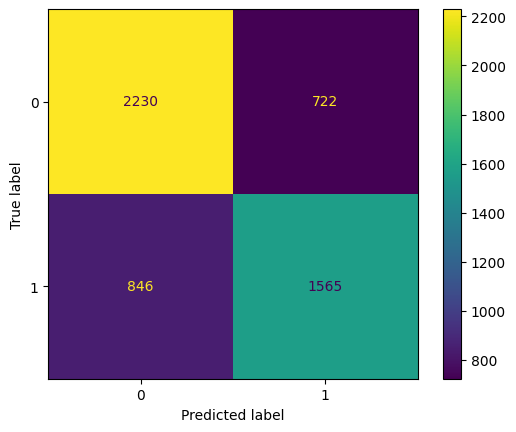

In [45]:


ConfusionMatrixDisplay.from_predictions(np.argmax(y_test,axis=1),np.argmax(best_models['accuracy'][2],axis=1))
print("Best Model Accuracy:", best_models['accuracy'][1])



In [55]:
atac_model = keras.models.load_model(best_models['loss'][0])
atac_model_copy = keras.models.clone_model(atac_model)
atac_model_copy.set_weights(atac_model.get_weights())

In [98]:
atac_model.set_weights(atac_model_copy.get_weights())

In [99]:
atac_layers = [layer.name for layer in atac_model.layers]
for l in atac_layers:
    print(l)

conv_0
conv_bn_0
activation
conv_1
conv_bn_1
activation_1
conv_2
conv_bn_2
activation_2
conv_3
conv_bn_3
activation_3
conv_4
conv_bn_4
activation_4
pool_4
flatten
dense
dense_bn_0
activation_5
MCD_0
dense_1
dense_bn_1
activation_6
MCD_1
output


In [100]:
combined_1 = keras.models.Sequential(atac_model.layers[:15])
combined_1.add(layers.Conv1D(filters=180,kernel_size=3,padding='same',name='conv_5'))
combined_1.add(layers.BatchNormalization(name='conv_bn_5'))
combined_1.add(layers.Activation('relu', name='activation_5'))
combined_1.add(layers.MaxPooling1D(pool_size=4, name='pool'))
combined_1.add(layers.Flatten())

dense_layers = 2
dense_neurons = 128
pool_size=3
dropout=0.4

for i in range(dense_layers):
        combined_1.add(layers.Dense(units=dense_neurons))
        combined_1.add(layers.BatchNormalization(name='dense_bn_'+str(i)))
        combined_1.add(layers.Activation('relu',name='activation_'+str(6+i)))
        combined_1.add(layers.Dropout(dropout, name='MCD_'+str(i)))
        
combined_1.add(layers.Dense(units=1, activation='linear', name='output'))

for layer in combined_1.layers[:15]:
        layer.trainable=False

combined_1.compile(loss='mae',optimizer=keras.optimizers.Adam(learning_rate=1e-3))

for l in combined_1.layers:
    print(l.name)

conv_0
conv_bn_0
activation
conv_1
conv_bn_1
activation_1
conv_2
conv_bn_2
activation_2
conv_3
conv_bn_3
activation_3
conv_4
conv_bn_4
activation_4
conv_5
conv_bn_5
activation_5
pool
flatten_1
dense_15
dense_bn_0
activation_6
MCD_0
dense_16
dense_bn_1
activation_7
MCD_1
output


In [101]:
genomic_df = pd.read_csv('Data/genomic.csv', index_col=0)
FEATURE_KEY = 'sequence'
LABEL_KEY = 'expression_log2'
test_df = genomic_df[genomic_df['test_set']]
validation_df = genomic_df[genomic_df['validation_set']]
train_df = genomic_df[genomic_df['train_set']]

x_test = one_hot_seqs(test_df[FEATURE_KEY])
x_validation = one_hot_seqs(validation_df[FEATURE_KEY])
x_train = one_hot_seqs(train_df[FEATURE_KEY])

y_test = test_df[LABEL_KEY].values
y_validation = validation_df[LABEL_KEY].values
y_train = train_df[LABEL_KEY].values


In [104]:
x = x_train.astype('float')
y = y_train.astype('float')
x_val = x_validation.astype('float')
earlystop_cb = keras.callbacks.EarlyStopping('val_loss', patience=15)

hitsory1 = combined_1.fit(
    x,
    y,
    validation_data=(x_validation, y_validation),
    epochs=100,
    callbacks=[earlystop_cb]
)


Epoch 1/100
105/105 [==============================] - 7s 65ms/step - loss: 1.0771 - val_loss: 1.8132
Epoch 2/100
105/105 [==============================] - 7s 62ms/step - loss: 1.0014 - val_loss: 1.7456
Epoch 3/100
105/105 [==============================] - 7s 63ms/step - loss: 0.9459 - val_loss: 1.7694
Epoch 4/100
105/105 [==============================] - 6s 62ms/step - loss: 0.9038 - val_loss: 1.9698
Epoch 5/100
105/105 [==============================] - 7s 62ms/step - loss: 0.8659 - val_loss: 1.7715
Epoch 6/100
105/105 [==============================] - 6s 62ms/step - loss: 0.8424 - val_loss: 1.8431
Epoch 7/100
105/105 [==============================] - 6s 62ms/step - loss: 0.8246 - val_loss: 1.7121
Epoch 8/100
105/105 [==============================] - 6s 62ms/step - loss: 0.7957 - val_loss: 2.0191
Epoch 9/100
105/105 [==============================] - 7s 62ms/step - loss: 0.7670 - val_loss: 1.7624
Epoch 10/100
105/105 [==============================] - 6s 62ms/step - loss: 0.764

In [105]:
stats = cc_performance(combined_1,x_test.astype('float'),y_test)
stats

(20, 414)


pcc    0.273716
scc    0.283964
Name: metrics, dtype: float64